# Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import ML_lib
import importlib
import os

# for debug purposes, reload the module to reflect recent changes
importlib.reload(ML_lib)

<module 'ML_lib' from 'c:\\Users\\maxim\\Godot Games\\Snake\\python-test-folder\\ML_lib.py'>

# Loading CSV data

In [14]:
def load_and_preprocess_data(data_path):
    # iterate over all the csv files in the data_path, remove the header and combine them into one np.array
    data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    data_list = []

    print(f"Found {len(data_files)} csv files in {data_path}")

    for file in data_files:
        file_path = os.path.join(data_path, file)
        try:
            data = np.loadtxt(file_path, delimiter=',', skiprows=1)
            if data.size > 0:
                # Ensure 2D array even if single line
                if len(data.shape) == 1:
                    data = data.reshape(1, -1)
                
                #'No Input' ([0,0,0,0]) changed to Last Direction
                # Default to [0, 1, 0, 0] (Right), the game starts with no input
                last_action = np.array([0, 1, 0, 0], dtype=data.dtype)

                for i in range(len(data)):
                    # Check the last 4 columns (targets)
                    current_y = data[i, -4:]
                    
                    # If sum is 0, it means no key was pressed -> Snake continues previous direction
                    if np.sum(current_y) == 0:
                        data[i, -4:] = last_action
                    else:
                        # New input found, update the last known action
                        last_action = current_y

                data_list.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_list:
        print("No data loaded.")
        return None, None

    combined_data = np.concatenate(data_list, axis=0)
    print(f"Original combined shape: {combined_data.shape}")

    # Filter rows where score (col 1) resets to 0 in the next row, but is not 0 itself
    # Allow to remove the actions that lead to game over
    # Logic: (current_score != 0) AND (next_score == 0) -> Remove current
    
    to_remove = np.zeros(len(combined_data), dtype=bool)
    
    # Check condition for all rows except the last one
    # Column 1 is the score column
    to_remove[:-1] = (combined_data[:-1, 1] != 0) & (combined_data[1:, 1] == 0)
    
    num_removed = np.sum(to_remove)
    print(f"Removing {num_removed} rows where score resets to 0.")
    
    if num_removed > 0:
        final_scores = combined_data[to_remove, 1]
        avg_score = np.mean(final_scores)
        max_score = np.max(final_scores)
        print(f"Statistics over {num_removed} games:")
        print(f"  - Average Score: {avg_score:.2f}")
        print(f"  - Max Score: {max_score}")
    else:
        print("No game resets detected (Average Score cannot be computed).")

    combined_data_filtered = combined_data[~to_remove]
    
    # Remove the first column (index 0) gameOver not relevant
    combined_data_final = combined_data_filtered[:, 1:]
    
    print(f"Shape after filtering rows and removing first column: {combined_data_final.shape}")

    # use the last 4 row as the prediction and the rest as the features
    X = combined_data_final[:, :-4]
    Y = combined_data_final[:, -4:]

    print(f"Final X shape: {X.shape}")
    print(f"Final Y shape: {Y.shape}")
    
    # print the size of X in MB
    print("Size of X: ", X.nbytes / 1e6, "MB")
    
    return X, Y

In [15]:
X, Y = load_and_preprocess_data("../Data/")

Found 4 csv files in ../Data/
Original combined shape: (46845, 525)
Removing 149 rows where score resets to 0.
Statistics over 149 games:
  - Average Score: 17.53
  - Max Score: 67.0
Shape after filtering rows and removing first column: (46696, 524)
Final X shape: (46696, 520)
Final Y shape: (46696, 4)
Size of X:  194.25536 MB


Training Perceptron for Up...
Training Perceptron for Right...
Training Perceptron for Down...
Training Perceptron for Left...


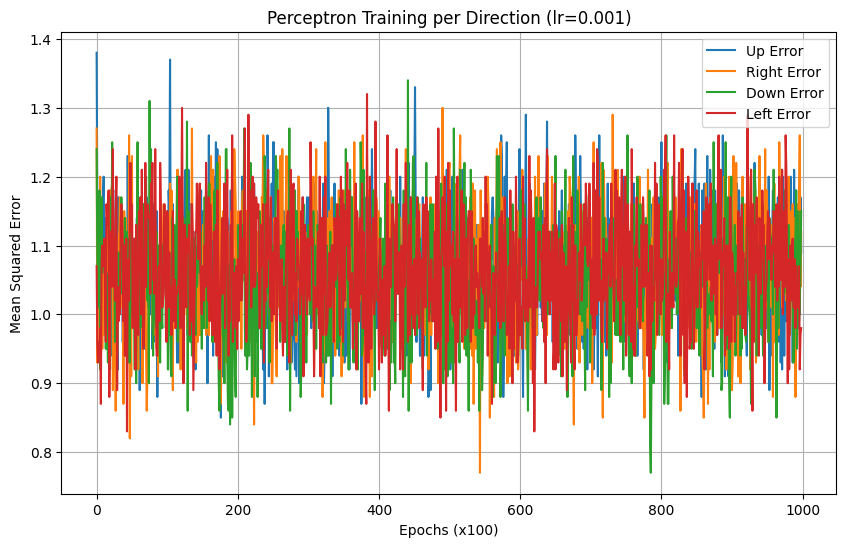

Training Complete. Models saved.


In [17]:
input_size = X.shape[1]
num_iter = 100_000
lr = 0.001

directions = ["Up", "Right", "Down", "Left"]
models = []
errors_list = []

plt.figure(figsize=(10, 6))

for i, direction in enumerate(directions):
    print(f"Training Perceptron for {direction}...")

    p_model = ML_lib.PerceptronModel(input_size)
    models.append(p_model)

    # Extract only the column for this direction (Shape: N,)
    # Reshape to (N, 1)
    Y_target = Y[:, i].reshape(-1, 1)

    # Train
    error_history = p_model.train(X, Y_target, epochs=num_iter, learning_rate=lr)
    errors_list.append(error_history)

    plt.plot(error_history, label=f"{direction} Error")
    
    p_model.save(f"../Models/Perceptron_{direction}.bin")

plt.xlabel("Epochs (x100)")
plt.ylabel("Mean Squared Error")
plt.title(f"Perceptron Training per Direction (lr={lr})")
plt.legend()
plt.grid(True)
plt.show()

print("Training Complete. Models saved.")

In [23]:
# Predict 10 random samples from X and print them and the corresponding Y
for idx in range(10):
    x_sample = X[idx, :].reshape(-1, 1)
    y_true = Y[idx, :].reshape(-1, 1)
    y_pred = mlp.predict(x_sample)
    print(f"Sample {idx}:")
    print(f"  True Output: {y_true.ravel()}")
    print(f"  Predicted Output: {y_pred.ravel()}")

Sample 0:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.14113866 0.36576603 0.09838473 0.22377292]
Sample 1:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.12914765 0.37673095 0.0938632  0.24193873]
Sample 2:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.0936669  0.48093405 0.07260266 0.21465301]
Sample 3:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.06801884 0.56274006 0.05424716 0.18047703]
Sample 4:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.03891821 0.63343922 0.04951712 0.19009129]
Sample 5:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.05858032 0.38525329 0.16358985 0.24856902]
Sample 6:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.04505444 0.38448691 0.17528585 0.25093782]
Sample 7:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.07107595 0.42606078 0.09432156 0.28326491]
Sample 8:
  True Output: [0. 0. 0. 1.]
  Predicted Output: [0.08521787 0.3057969  0.16164284 0.31243434]
Sample 9:
  True Output: [0. 0. 0. 1.]
  Predicted Outp

In [24]:
path = f"..\\Models\\{X.shape[0]}X_{NPL}_{num_iter}iter_{lr}lr_{train_proportion}train.bin"
mlp.save(path)
print(f"Model saved to {path}")

Model saved to ..\Models\Maxime_20159X_[520, 128, 64, 4]_400000iter_0.001lr_0.9train.bin
